In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import os, glob
import tensorflow as tf
from tqdm import tqdm
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
from keras.models import Model, Sequential, Input, load_model
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization, GlobalAveragePooling2D,Activation
from tensorflow.keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator

In [7]:
data_dir = 'D:\DL\Food image Classification\CODE\Food/'

In [8]:
Food=[]
for file in os.listdir(data_dir):
    Food+=[file]
print(Food)
print(len(Food))

['apple_pie', 'cannoli', 'cheesecake', 'cheese_plate', 'chicken_wings', 'chocolate_cake', 'deviled_eggs', 'donuts', 'french_fries', 'frozen_yogurt', 'ice_cream', 'macarons']
12


In [9]:
datagen = ImageDataGenerator(rescale = 1./255, validation_split = 0.2)

In [10]:
train_data = datagen.flow_from_directory(data_dir, target_size = (128,128), batch_size = 15, class_mode = 'categorical',
                                        subset = 'training')

val_data = datagen.flow_from_directory(data_dir, target_size = (128,128), batch_size = 15, class_mode = 'categorical',
                                        subset = 'validation')

Found 9600 images belonging to 12 classes.
Found 2400 images belonging to 12 classes.


In [11]:
model = Sequential()
model.add(Conv2D(filters=32, kernel_size=(3,3), padding='Same', activation='relu', input_shape=(128, 128, 3)))
model.add(MaxPool2D(pool_size=(2,2)))

model.add(Conv2D(filters=64, kernel_size=(3,3), padding='Same', activation='relu'))
model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))

model.add(Conv2D(filters=96, kernel_size=(3,3), padding='Same', activation='relu'))
model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))

model.add(Conv2D(filters=96, kernel_size=(3,3), padding='Same', activation='relu'))
model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))

model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dense(12, activation="softmax"))


model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 128, 128, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 64, 64, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 96)        55392     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 16, 16, 96)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 16, 16, 96)        8

In [12]:
model.compile(optimizer="adam",loss="categorical_crossentropy",metrics=['accuracy'])
history = model.fit(train_data, epochs = 10, verbose = 1,validation_data=val_data)

Epoch 1/10
640/640 [==============================] - 577s 896ms/step - loss: 2.4250 - accuracy: 0.1349 - val_loss: 2.3191 - val_accuracy: 0.1967
Epoch 2/10
640/640 [==============================] - 234s 365ms/step - loss: 2.1991 - accuracy: 0.2344 - val_loss: 2.1996 - val_accuracy: 0.2446
Epoch 3/10
640/640 [==============================] - 235s 366ms/step - loss: 2.0508 - accuracy: 0.2928 - val_loss: 2.0748 - val_accuracy: 0.2871
Epoch 4/10
640/640 [==============================] - 212s 331ms/step - loss: 1.9029 - accuracy: 0.3477 - val_loss: 2.0321 - val_accuracy: 0.3096
Epoch 5/10
640/640 [==============================] - 211s 330ms/step - loss: 1.7139 - accuracy: 0.4159 - val_loss: 2.0190 - val_accuracy: 0.3258
Epoch 6/10
640/640 [==============================] - 226s 354ms/step - loss: 1.4673 - accuracy: 0.5075 - val_loss: 2.1850 - val_accuracy: 0.3167
Epoch 7/10
640/640 [==============================] - 230s 359ms/step - loss: 1.1184 - accuracy: 0.6250 - val_loss: 2.5567 -

In [13]:
model.evaluate(val_data)
model.save("D:\DL\Food image Classification\CODE\models\CNN.h5")

160/160 [==============================] - 11s 70ms/step - loss: 4.7703 - accuracy: 0.2763


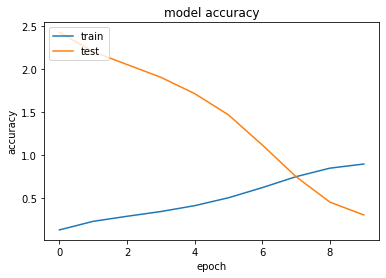

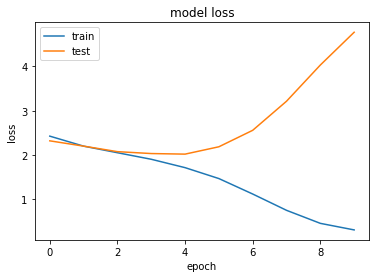

In [14]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [15]:
ReLU = tf.keras.layers.ReLU()

In [16]:
def fire_module(x,s1,e1,e3):
    s1x = Conv2D(s1,kernel_size = 1, padding = 'same')(x)
    s1x = ReLU()(s1x)
    e1x = Conv2D(e1,kernel_size = 1, padding = 'same')(s1x)
    e3x = Conv2D(e3,kernel_size = 3, padding = 'same')(s1x)
    x = concatenate([e1x,e3x])
    x = ReLU()(x)
    return x

In [17]:
def SqueezeNet(input_shape=(64,64,3), nclasses=12):
    input = Input(input_shape)
    x = Conv2D(96,kernel_size=(7,7),strides=(2,2),padding='same')(input)
    x = MaxPool2D(pool_size=(3,3), strides = (2,2))(x)
    x = fire_module(x, s1 = 16, e1 = 64, e3 = 64) #2
    x = fire_module(x, s1 = 16, e1 = 64, e3 = 64) #3
    x = fire_module(x, s1 = 32, e1 = 128, e3 = 128) #4
    x = MaxPool2D(pool_size=(3,3), strides = (2,2))(x)
    x = fire_module(x, s1 = 32, e1 = 128, e3 = 128) #5
    x = fire_module(x, s1 = 48, e1 = 192, e3 = 192) #6
    x = fire_module(x, s1 = 48, e1 = 192, e3 = 192) #7
    x = fire_module(x, s1 = 64, e1 = 256, e3 = 256) #8
    x = MaxPool2D(pool_size=(3,3), strides = (2,2))(x)
    x = fire_module(x, s1 = 64, e1 = 256, e3 = 256) #9
    x = Dropout(0.5)(x)
    x = Conv2D(nclasses,kernel_size = 1)(x)
    output = AvgPool2D(pool_size=(13,13))(x)
    model = Model(input, output)
    return model
model1=model
model1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 128, 128, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 64, 64, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 96)        55392     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 16, 16, 96)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 16, 16, 96)        8

In [18]:
model1.compile(optimizer="adam",loss="categorical_crossentropy",metrics=['accuracy'])
history1 = model1.fit(train_data, epochs = 10, verbose = 1,validation_data=val_data)

Epoch 1/10
640/640 [==============================] - 200s 312ms/step - loss: 0.2479 - accuracy: 0.9197 - val_loss: 5.5643 - val_accuracy: 0.2925
Epoch 2/10
640/640 [==============================] - 199s 311ms/step - loss: 0.1534 - accuracy: 0.9541 - val_loss: 6.3344 - val_accuracy: 0.2700
Epoch 3/10
640/640 [==============================] - 199s 311ms/step - loss: 0.1451 - accuracy: 0.9570 - val_loss: 6.6995 - val_accuracy: 0.2858
Epoch 4/10
640/640 [==============================] - 203s 318ms/step - loss: 0.1305 - accuracy: 0.9586 - val_loss: 6.4741 - val_accuracy: 0.2763
Epoch 5/10
640/640 [==============================] - 192s 300ms/step - loss: 0.1220 - accuracy: 0.9615 - val_loss: 7.1659 - val_accuracy: 0.2642
Epoch 6/10
640/640 [==============================] - 196s 306ms/step - loss: 0.1269 - accuracy: 0.9629 - val_loss: 7.0884 - val_accuracy: 0.2804
Epoch 7/10
640/640 [==============================] - 199s 311ms/step - loss: 0.0999 - accuracy: 0.9671 - val_loss: 6.9236 -

In [19]:
model1.evaluate(val_data)
model1.save("D:\DL\Food image Classification\CODE\models\SqueezeNet.h5")

160/160 [==============================] - 12s 72ms/step - loss: 8.7339 - accuracy: 0.2717


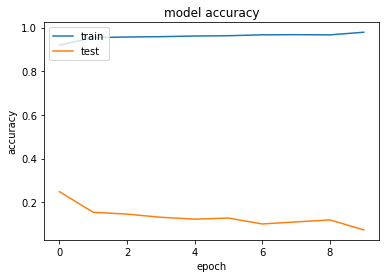

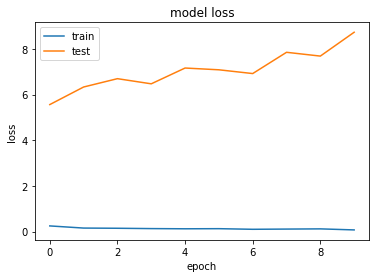

In [20]:
plt.plot(history1.history['accuracy'])
plt.plot(history1.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.plot(history1.history['loss'])
plt.plot(history1.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [21]:
base_model2 = tf.keras.applications.VGG16(input_shape=(64, 64, 3), include_top=False,
                          weights='imagenet')
model2 = Sequential()
model2.add(base_model2)
model2.add(GlobalAveragePooling2D())
model2.add(Dense(64, activation='relu'))
model2.add(BatchNormalization())
model2.add(Dropout(0.2))
model2.add(Dense(12, activation='sigmoid'))
model2.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 2, 2, 512)         14714688  
_________________________________________________________________
global_average_pooling2d (Gl (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 64)                32832     
_________________________________________________________________
batch_normalization (BatchNo (None, 64)                256       
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 12)                780       
Total params: 14,748,556
Trainable params: 14,748,428
Non-trainable params: 128
________________________________________

In [22]:
model2.compile(optimizer="adam",loss="categorical_crossentropy",metrics=['accuracy'])
history2 = model2.fit(train_data, epochs = 10, verbose = 1,validation_data=val_data)

Epoch 1/10
640/640 [==============================] - 2498s 4s/step - loss: 2.4596 - accuracy: 0.1262 - val_loss: 2.4620 - val_accuracy: 0.1467
Epoch 2/10
640/640 [==============================] - 2429s 4s/step - loss: 2.3604 - accuracy: 0.1491 - val_loss: 2.4624 - val_accuracy: 0.1275
Epoch 3/10
640/640 [==============================] - 2403s 4s/step - loss: 2.3132 - accuracy: 0.1620 - val_loss: 2.4913 - val_accuracy: 0.1063
Epoch 4/10
640/640 [==============================] - 2397s 4s/step - loss: 2.2754 - accuracy: 0.1710 - val_loss: 2.2663 - val_accuracy: 0.1713
Epoch 5/10
640/640 [==============================] - 2316s 4s/step - loss: 2.2556 - accuracy: 0.1832 - val_loss: 2.2767 - val_accuracy: 0.1771
Epoch 6/10
640/640 [==============================] - 2294s 4s/step - loss: 2.2334 - accuracy: 0.1817 - val_loss: 3.2885 - val_accuracy: 0.1133
Epoch 7/10
640/640 [==============================] - 41470s 65s/step - loss: 2.2150 - accuracy: 0.1845 - val_loss: 39314.4883 - val_acc

In [23]:
model2.evaluate(val_data)

160/160 [==============================] - 111s 690ms/step - loss: 2.5772 - accuracy: 0.1033


[2.5771968364715576, 0.10333333164453506]

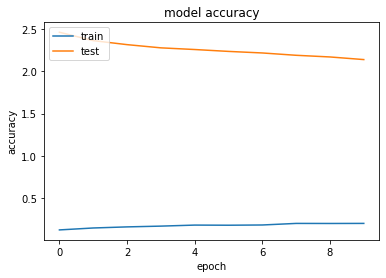

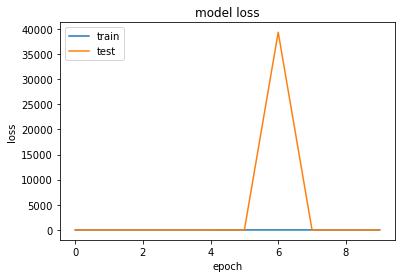

In [24]:
plt.plot(history2.history['accuracy'])
plt.plot(history2.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.plot(history2.history['loss'])
plt.plot(history2.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [25]:
model2.save("D:\DL\Food image Classification\CODE\models\VGG16.h5")

In [26]:
base_model3 = tf.keras.applications.ResNet50(input_shape=(64, 64, 3), include_top=False,
                          weights='imagenet')
model3 = Sequential()
model3.add(base_model3)
model3.add(GlobalAveragePooling2D())
model3.add(Dense(64, activation='relu'))
model3.add(BatchNormalization())
model3.add(Dropout(0.2))
model3.add(Dense(12, activation='sigmoid'))
model3.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 2, 2, 2048)        23587712  
_________________________________________________________________
global_average_pooling2d_1 ( (None, 2048)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 64)                131136    
_________________________________________________________________
batch_normalization_1 (Batch (None, 64)                256       
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 12)                780       
Total params: 23,719,884
Trainable params: 23,666,636
Non-trainable params: 53,248
_____________________________________

In [27]:
model3.compile(optimizer="adam",loss="categorical_crossentropy",metrics=['accuracy'])
history3 = model3.fit(train_data, epochs = 10, verbose = 1,validation_data=val_data)

Epoch 1/10
640/640 [==============================] - 1511s 2s/step - loss: 2.5649 - accuracy: 0.1126 - val_loss: 2.4849 - val_accuracy: 0.0875
Epoch 2/10
640/640 [==============================] - 1873s 3s/step - loss: 2.4503 - accuracy: 0.1399 - val_loss: 4.0513 - val_accuracy: 0.1308
Epoch 3/10
640/640 [==============================] - 1659s 3s/step - loss: 2.4015 - accuracy: 0.1430 - val_loss: 13.2534 - val_accuracy: 0.1029
Epoch 4/10
640/640 [==============================] - 1686s 3s/step - loss: 2.3703 - accuracy: 0.1608 - val_loss: 23.5734 - val_accuracy: 0.1587
Epoch 5/10
640/640 [==============================] - 1548s 2s/step - loss: 2.3153 - accuracy: 0.1833 - val_loss: 10.3347 - val_accuracy: 0.0925
Epoch 6/10
640/640 [==============================] - 1627s 3s/step - loss: 2.2847 - accuracy: 0.2023 - val_loss: 15.4422 - val_accuracy: 0.0838
Epoch 7/10
640/640 [==============================] - 1642s 3s/step - loss: 2.3636 - accuracy: 0.1709 - val_loss: 2.4978 - val_accur

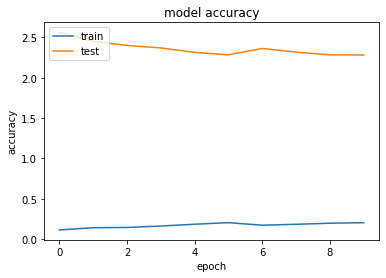

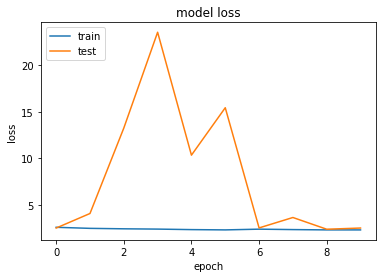

In [31]:
plt.plot(history3.history['accuracy'])
plt.plot(history3.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.plot(history3.history['loss'])
plt.plot(history3.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()                                  

In [28]:
model3.save("D:\DL\Food image Classification\CODE\models\ResNet50.h5")

C:\Users\YMTS0427\AppData\Roaming\Python\Python36\site-packages\keras\utils\generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


In [29]:
Accuracy = []

for i in [history, history1, history2,history3]:
    x = i.history.get('accuracy')[-1]
    Accuracy.append(x)

Accuracy

[0.8984375, 0.9788541793823242, 0.203125, 0.20239582657814026]

[9.9999821e-01 2.0813228e-15 1.4153478e-07 4.8558019e-10 3.0403216e-15
 5.2833338e-10 5.9558639e-15 6.1885629e-07 2.4819218e-07 3.1090155e-11
 2.7419185e-07 5.6356743e-07]


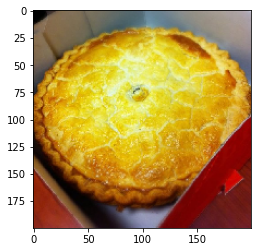

Prediction: apple_pie


In [34]:
from skimage import io
from keras.preprocessing import image

img = image.load_img(r'D:\DL\Food image Classification\CODE\Food\apple_pie\416233.jpg', grayscale=False, target_size=(128,128))
show_img=image.load_img(r'D:\DL\Food image Classification\CODE\Food\apple_pie\416233.jpg', grayscale=False, target_size=(200, 200))
Food = Food
x = image.img_to_array(img)
x = np.expand_dims(x, axis = 0)

x /= 255

custom = model1.predict(x)
print(custom[0])


plt.imshow(show_img)
plt.show()

a=custom[0]
ind=np.argmax(a)
        
print('Prediction:',Food[ind])